In [2]:
import sys
from collections import defaultdict, OrderedDict
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

import albumentations as alb
import json
import torch
import numpy as np
import pandas as pd
from torchvision.ops import box_iou

from dataset import create_dataloaders
import config as cfg
from utils import tensor2rgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering

seed = 123
np.random.seed(seed)

In [3]:
def preprocess_data(img, annotation, max_size=800):
    transform = alb.Compose([
        alb.SmallestMaxSize(max_size=max_size, interpolation=1)],
        bbox_params=alb.BboxParams(format='pascal_voc',
                                   min_area=0,
                                   min_visibility=0,
                                   label_fields=['bboxes_labels']),
        keypoint_params=alb.KeypointParams(format='xy', remove_invisible=False))
    
    transformed = transform(image=tensor2rgb(img),
                            keypoints=annotation["keypoints"],
                            bboxes=annotation["boxes"],
                            bboxes_labels=annotation["labels"])

    return transformed


dataloader = create_dataloaders(transform_train=False)["train"]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!

TRAINING IMAGES NUMBER: 233
VALIDATION IMAGES NUMBER: 29
TESTING IMAGES NUMBER: 29

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


# General

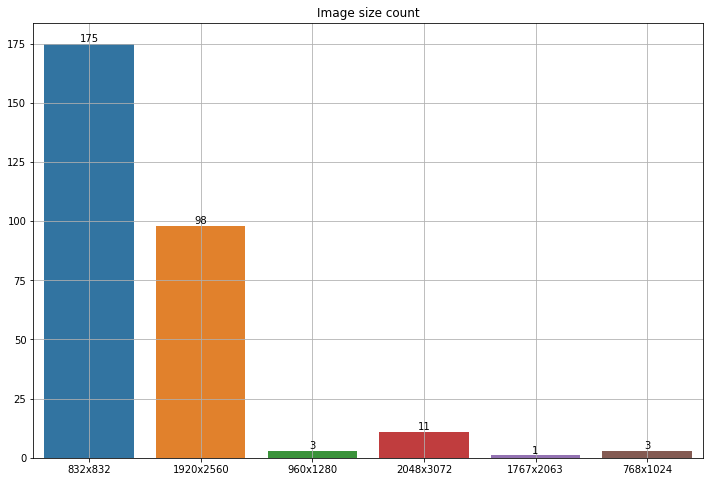

In [70]:
with open(cfg.ANNOTATION_FILE_PATH, "r") as file:
    annotation_file = json.load(file)
    
img_sizes = defaultdict(lambda: 0)

for img_data in annotation_file["images"]:
    img_sizes[f"{img_data['height']}x{img_data['width']}"] += 1
    
plt.figure(figsize=(12,8))
plt.title("Image size count")
ax = sns.barplot(x=list(img_sizes.keys()), y=list(img_sizes.values()))
ax.bar_label(ax.containers[0])
ax.grid(True);

OrderedDict([(1, 2483), (2, 240), (3, 678)])


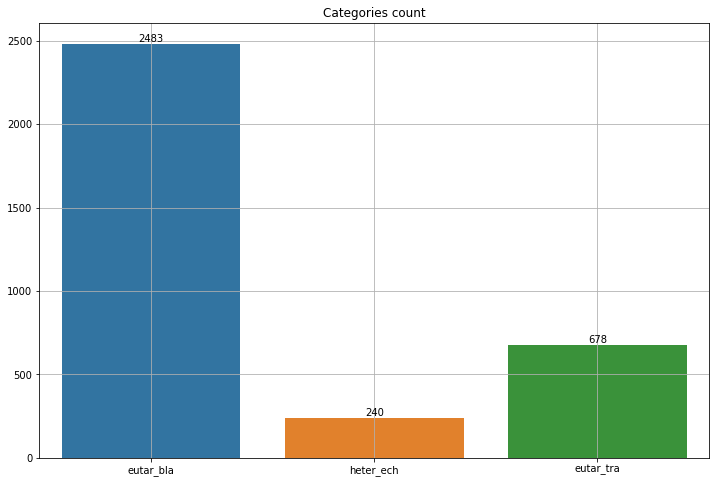

In [71]:
category_names = ['eutar_bla', 'heter_ech', 'eutar_tra']

categories = OrderedDict()
for i in range(1, 4):
    categories[i] = 0
    
for annotation_data in annotation_file["annotations"]:
    categories[annotation_data["category_id"]] += 1
    
print(categories)
    
plt.figure(figsize=(12,8))
plt.title("Categories count")
ax = sns.barplot(x=category_names, y=list(categories.values()))
ax.bar_label(ax.containers[0])
ax.grid(True);

# Boxes

In [6]:
def rescale_bboxes():
    bboxes_scaled = []
    for img, annotation in dataloader:
        bboxes_scaled.extend(preprocess_data(img, annotation[0])["bboxes"])
    bboxes_scaled = np.array(bboxes_scaled, dtype=np.float32)
    return bboxes_scaled

In [7]:
bboxes_rescaled = rescale_bboxes()

In [8]:
df = pd.DataFrame(bboxes_rescaled, columns = ["x_min", "y_min", "x_max", "y_max"])
df["height"] = df.y_max - df.y_min
df["width"] = df.x_max - df.x_min
df["x_center"] = df.x_min + (df.width / 2) 
df["y_center"] = df.y_min + (df.height / 2)
df["ratio"] = df.height / df.width
df.describe()

,x_min,y_min,x_max,y_max,height,width,x_center,y_center,ratio
count,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000
mean,454.689819,374.387817,513.234802,439.588715,65.201187,58.545105,483.962646,406.988678,1.335035
std,207.791000,172.342865,202.352829,172.587814,48.352764,41.785347,204.023087,170.762421,0.881135
min,0.000000,0.000000,52.343750,32.083332,5.833334,6.668732,27.884615,21.041668,0.199938
25%,301.865150,225.000000,352.610138,294.843765,30.833313,27.925354,324.690140,257.211548,0.688727
50%,479.524796,382.916656,532.666382,433.333344,51.938110,47.514832,509.429962,407.187515,1.105857
75%,593.935547,515.683578,655.732300,583.750000,87.812500,77.524277,619.711548,553.822098,1.743214
max,1111.328125,762.500000,1167.578125,800.000000,400.000000,269.230743,1139.453125,778.750000,6.307691


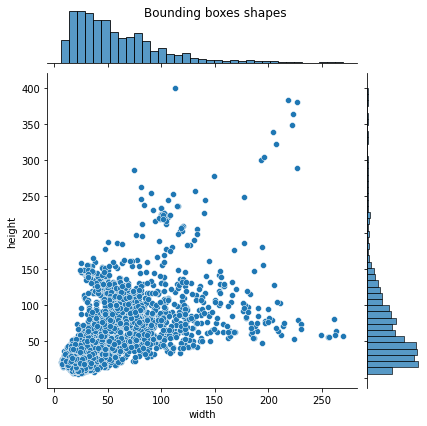

In [81]:
plot = sns.jointplot(x="width", y="height", data=df)
plot.fig.suptitle("Bounding boxes shapes");

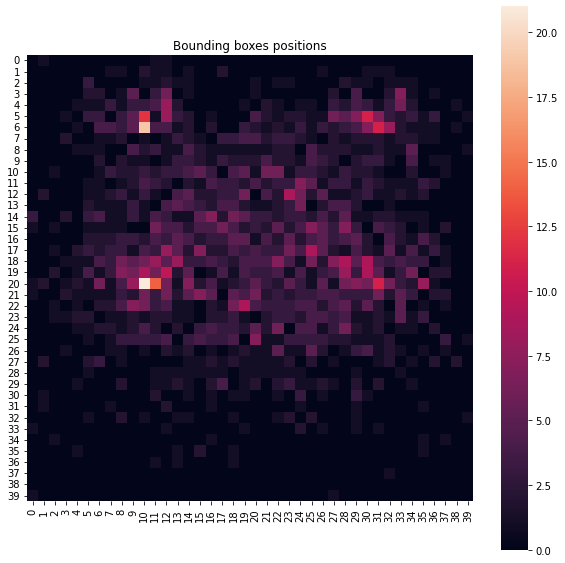

In [76]:
plt.figure(figsize=(10, 10))
plt.title("Bounding boxes positions")
bins = 40
df_boxes = df[["x_center", "y_center"]]
H, xedges, yedges = np.histogram2d(df.x_center, df.y_center, bins=bins)
ax = sns.heatmap(H, square=True);

In [11]:
df_size = pd.concat([df.height, df.width], ignore_index=True)
df_size

0        50.961548
1       101.923050
2       102.884644
3       111.538452
4       159.615356
           ...    
4447     15.838287
4448     23.757446
4449     23.757416
4450     27.925415
4451     17.088623
Length: 4452, dtype: float32

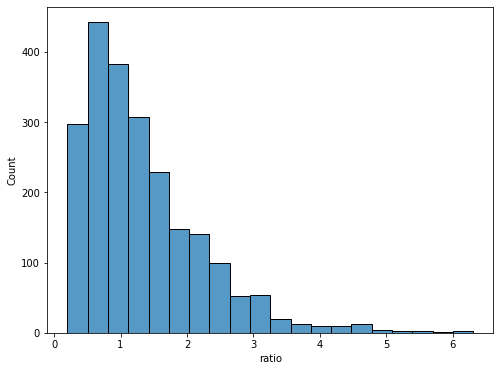

In [84]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df.ratio, bins=20);

## Anchor boxes

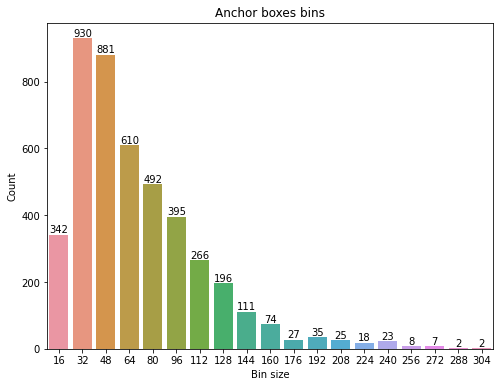

In [87]:
plt.figure(figsize=(8, 6))
hist, bins = np.histogram(df_size, bins=[i * 16 for i in range(20)])
plt.title("Anchor boxes bins")
ax = sns.barplot(x=bins[1:], y=hist)
ax.bar_label(ax.containers[0])
ax.set_xlabel("Bin size")
ax.set_ylabel("Count");

In [88]:
# Box size with the max count
df_hist.loc[[df_hist["hist"].idxmax()]]

,bins,hist
1,32,930


In [89]:
X = df[['height', 'width']].values

### Euclidean distance clustering

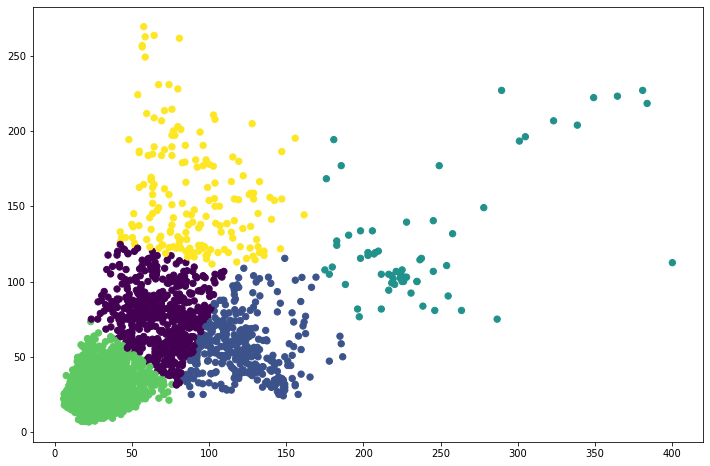

In [66]:
K = KMeans(5, random_state=seed)
k_fitted = K.fit(X)

plt.figure(figsize=(12, 8))
plt.title("K-Means euclidean distance clusters")
plt.scatter(X[:, 0], X[:, 1], c=k_fitted.labels_, s=40);

In [60]:
centers = k_fitted.cluster_centers_
ratios = centers[:,0] / centers[:,1]
sizes = centers[:,1] * np.sqrt(ratios)
print(f"Sizes: {sorted(sizes)}")
print(f"Aspect ratios: {sorted(ratios)}")

Sizes: [30.261026, 73.03608, 82.27939, 118.1659, 173.14278]
Aspect ratios: [0.5717323, 0.8956611, 1.0533805, 1.8891797, 2.1743042]


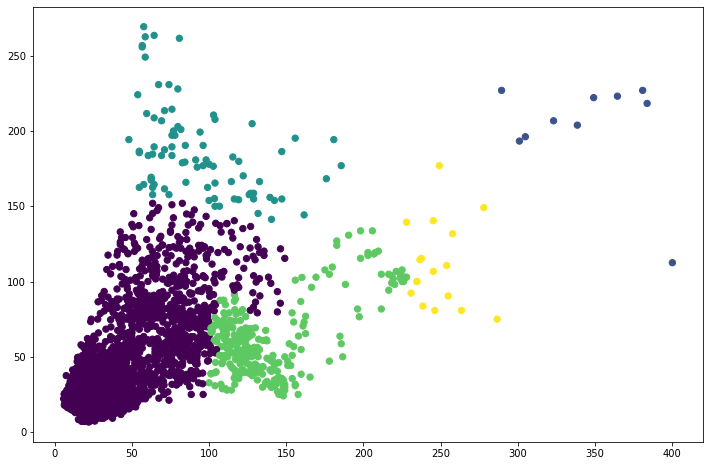

In [67]:
ac = AgglomerativeClustering(n_clusters=5, affinity='euclidean', 
                                  linkage='complete')  
ac_fitted = ac.fit(X)

plt.figure(figsize=(12, 8))
plt.title("AgglomerativeClustering euclidean distance clusters")
plt.scatter(X[:, 0], X[:, 1], c=ac_fitted.labels_, s=40);

In [62]:
df_ac = pd.DataFrame({"label": ac_fitted.labels_, "h": X[:, 0], "w": X[:, 1]})
df_ac_mean = df_ac.groupby("label").mean()
df_ac_mean

,h,w
label,,
0,49.445290,51.158348
1,343.461548,202.980759
2,93.252655,186.209930
3,137.421021,60.149250
4,248.246613,111.029411


In [21]:
ratios = df_ac_mean.h / df_ac_mean.w
sizes = df_ac_mean.w * np.sqrt(ratios)

print(f"Sizes: {sizes.values}")
print(f"Aspect Ratios: {ratios.values}")

Sizes: [ 50.294525 264.03806  131.7747    90.91629  166.0201  ]
Aspect Ratios: [0.9665146  1.6920892  0.50079316 2.2846673  2.2358634 ]


### Jaccard index clustering

In [51]:
np.random.seed(seed)


def iou(box, clusters):
    x_min = np.minimum(clusters[:, 0], box[0])
    y_min = np.minimum(clusters[:, 1], box[1])
    intersection_area = x_min * y_min
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    return intersection_area / (box_area + cluster_area - intersection_area)


def kmeans_iou(boxes, k):
    rows = boxes.shape[0]
    distances = np.empty((rows, k))
    clusters_last = np.zeros((rows,))
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        clusters_nearest = np.argmin(distances, axis=1)

        if (clusters_nearest == clusters_last).all():
            break

        for cluster in range(k):
            clusters[cluster] = np.median(boxes[clusters_nearest == cluster], axis=0)

        clusters_last = clusters_nearest

    return clusters

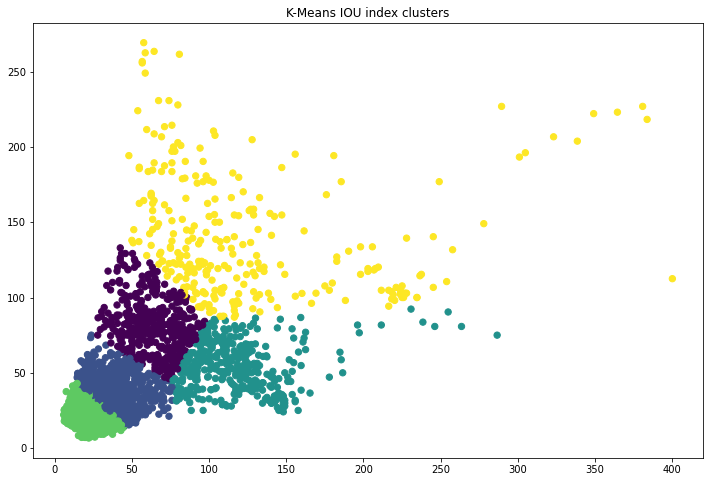

In [68]:
n_clusters=5
centers = kmeans_iou(X, n_clusters)
K = KMeans(n_clusters=n_clusters, init=centers, n_init=1)
k_fitted = K.fit(centers)
labels = k_fitted.predict(X)

plt.figure(figsize=(12, 8))
plt.title("K-Means IOU index clusters")
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40);

In [69]:
ratios = centers[:,0] / centers[:,1]
sizes = centers[:,1] * np.sqrt(ratios)

print(f"Sizes: {sizes}")
print(f"Aspect Ratios: {ratios}")

Sizes: [ 71.27066   38.753807  75.344696  20.4793   113.78583 ]
Aspect Ratios: [0.81707287 1.0214182  2.1858487  1.1409479  0.88911027]
